# Clustering

In [27]:
import os
import pysal as ps
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from math import ceil

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN

In [3]:
!pwd

/home/jovyan/work/i2p/lectures


In [4]:
df = pd.read_csv(os.path.join('..','data','clean','2020-08-24-listings.csv.gz'), low_memory=False)

(0.0, 1000.0)

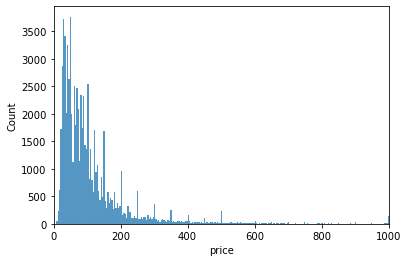

In [5]:
ax = sns.histplot(df.price)
ax.set_xlim([0,1000])

In [6]:
df.room_type.unique()

array(['Entire home/apt', 'Private room', 'Hotel room', 'Shared room'],
      dtype=object)

(31906, 54)


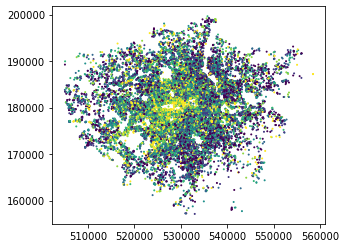

In [7]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude, crs='epsg:4326'))
gdf = gdf.to_crs('epsg:27700')
gdf = gdf[(gdf.room_type=='Private room') & (gdf.price < 600)]
gdf.plot(column='price', scheme='quantiles', k=7, markersize=1);
print(gdf.shape)

In [8]:
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}

In [9]:
gdf['x']   = gdf.geometry.x
gdf['y']   = gdf.geometry.y
gdf['lnp'] = np.log(gdf.price+1)

In [10]:
rs = RobustScaler(quantile_range=(10,90))
mm = MinMaxScaler(feature_range=(-1,1))
normed = gdf[['x','y','lnp']].copy()
for c in normed.columns.values:
    print(f"Normalising {c}")
    normed[c] = mm.fit_transform(rs.fit_transform(normed[c].values.reshape(-1,1)))
    #sns.histplot(normed[c], bins=200)
    print(f"\tRange is {normed[c].min()} - {normed[c].max()}")

Normalising x
	Range is -1.0 - 0.9999999999999999
Normalising y
	Range is -1.0 - 0.9999999999999999
Normalising lnp
	Range is -1.0 - 1.0


In [13]:
normed.mean()

x     -0.046314
y      0.107653
lnp    0.202724
dtype: float64

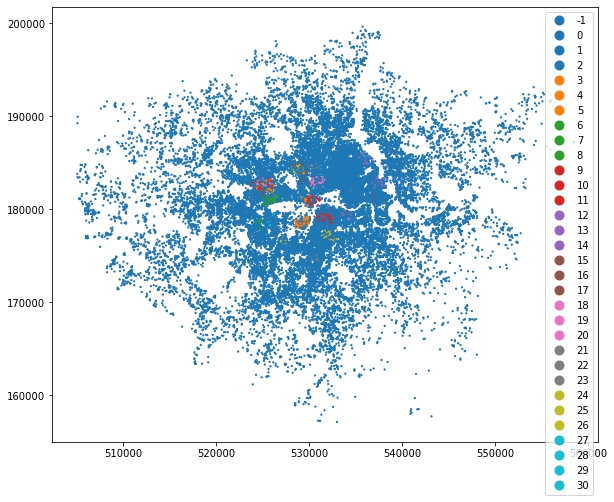

In [33]:
minPts = 25
epsilon = 0.025
dbsc = DBSCAN(eps=epsilon, min_samples=minPts)
dbsc.fit(normed)
clusters = dbsc.labels_

gdf['DBSCAN Cluster'] = clusters
gdf.plot(column='DBSCAN Cluster', categorical=True, legend=True, markersize=1.5, figsize=(12,8));